<a href="https://colab.research.google.com/github/rpalakkal/tensorflow/blob/master/TiramisuBackgroundRemover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background Removal with the Tiramisu Model

Background removal the process of isolating the subject of an image from the background and other objects. While it can be done by hand, machine learning has made the process a lot easier, especially for design professionals, who may require it for their work. The 100-Layer Tiramisu model(actually 103 layers including the input, and final two layers) is a fully convolutional neural network made for semantic segmentation. In this notebook we will implement a 100-layer Tiramisu model in Keras to perform background removal.

## Getting Started

Importing TensorFlow and Dependencies

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

TensorFlow 2.x selected.


We will be using the Caltech Birds dataset, which includes segmentation data. The segmentation masks are comprised of zeros and ones: a zero indicates that a pixel is a part of the bird, and a one indicates the pixel is part of the surroundings. This dataset is part of `tfds`, making it easy to use, and its relatively small size (compared to other segmentation datasets) makes the training time bearable.

In [0]:
dataset = tfds.load('caltech_birds2010')

Let us make a function to make processing the data easier. To reduce the training time even more, we will reshape the images to 64 x 64. We will also normalize the input image data by dividing by 255(so that values fall in [0, 1]). 

In [0]:
imgSize = 64
def processData(dataset):
  x, y = [], []
  for datapoint in dataset:
    resizedImg = tf.image.resize(datapoint['image'], (imgSize, imgSize))
    normalizedImg = (tf.cast(resizedImg, tf.float32) / 255).numpy()
    x.append(normalizedImg)

    resizedMask = tf.image.resize(datapoint['segmentation_mask'], (imgSize, imgSize))
    normalizedMask = (resizedMask).numpy()
    y.append(normalizedMask)

  return np.array(x), np.array(y)

Processing the Data

In [0]:
trainX, trainY = processData(dataset['train'])
testX, testY = processData(dataset['test'])

Let us check out a sample image and its segmentation mask.

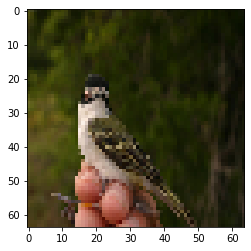

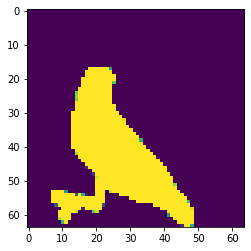

In [0]:
plt.imshow(trainX[0])
plt.show()
plt.imshow(trainY[0].reshape((64, 64)))
plt.show()

Let us remove the background from the image using the mask. To do so, we need to iterate through the mask array, making corresponding image pixels white if the mask pixel is zero. The `np.ndindex` tool allows us to iterate through the indices of the 3D mask array(which correspond with the indices of the image array).

In [0]:
def removeBg(image, mask):
  img = np.copy(image)
  for idx in np.ndindex(mask.shape[:2]):
    if mask[idx] == 0:
      img[idx]=np.array([255, 255, 255])
  return img

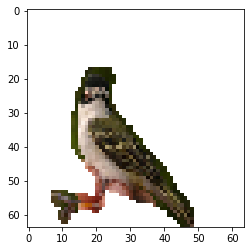

In [0]:
plt.imshow(removeBg(trainX[0],trainY[0]))
plt.show()

## Setting up the Tiramisu Model

The image below shows the general structure of the Tiramisu model. Let us look deeper into each part of the model.

![alt text](https://miro.medium.com/max/716/1*5Bqcgzl6JDXrScL1RXd6Ag.png)

Image Source - [Towards Data Science](https://miro.medium.com/max/716/1*5Bqcgzl6JDXrScL1RXd6Ag.png)

The 3 basic operations are shown below. As for Layer, it is used in each Dense Block. As seen in the picture above each Dense Block is accompanied by either a Transition Down or a Transition Up. In a way it is similar to an autoencoder, with the Dense Block shown at the bottom of the image serving as the bottleneck(the layer with the most dense representations). Let us implement these three core functions using Keras.

![alt text](https://miro.medium.com/max/1970/1*1Pj56mTHPNha8Pg58fWJEQ.png)
Image Source - [Towards Data Science](https://d3i71xaburhd42.cloudfront.net/1d9df46f672b1e22b6f210343be8684f88c0ccca/5-Table1-1.png)




In [0]:
def transitionDown(x, filters):
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.MaxPool2D(padding='same')(x)
    return x

In [0]:
def transitionUp(x, filters):
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(3, 3), strides=2, padding='same')(x)
    return x

In [0]:
def layer(x):
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  return x

The image below shows the architecture of each Dense Block and gives a description of how it works. The Dense Blocks vary in the amount of layers.

 Note: The last concatenation does not take the previous concatenation as an input unlike all the previous concatenations. 

![alt text](https://user-images.githubusercontent.com/22321977/48927515-5edfae00-ef11-11e8-83f2-1ba0fbc93fe8.png)

Image Source - [Towards Data Science](https://miro.medium.com/max/2200/1*7O7i_MiL55IrR3aum5guDw.jpeg)

In [0]:
def denseBlock(x, layers):
  outputBlock = []
  for i in range(layers-1):
    tmp = x
    x = layer(x)
    outputBlock.append(x) #store the output of each layer to be concatenated at the end 
    x = tf.keras.layers.concatenate([x, tmp])
  x = layer(x) 
  outputBlock.append(x)
  outputBlock = tf.keras.layers.concatenate(outputBlock)
  return outputBlock

Now, with a function for all the pieces of the model, we can put them together according to the 100 layer architecture. *m* represents the number of feature maps.

![alt text](https://miro.medium.com/max/349/1*F7CrNY8IPDtaXd-psASpvg.png)

Image Source - [Medium](https://miro.medium.com/max/349/1*F7CrNY8IPDtaXd-psASpvg.png)

By making one array with the number of layers and one for filters, we can iterate through them to generate the model.

In [0]:
layers = [4, 5, 7, 10, 12] #after the path down, flip the order of the layers
nbFilters = [112, 192, 304, 464, 656, 1088, 816, 578, 384, 256]
skipConnections=[] #to save concatenated layers to be used as skip connections

The input and first convolutional layer

In [0]:
input = tf.keras.layers.Input((imgSize, imgSize, 3))
x = keras.layers.Conv2D(48, kernel_size=(3, 3), padding='same')(input)

The Down Path: Dense Blocks followed by Transition Downs

In [0]:
for i in range(5):
  x = denseBlock(x, layers[i])
  skipConnections.append(x) #to use on the path up
  x = transitionDown(x, nbFilters[i])

The Bottleneck

In [0]:
x = denseBlock(x, 15)

Reversing the order of Skip Connections and Layers, and removing first 5 values from the array with number of filters

In [0]:
skipConnections = skipConnections[::-1]
layers = layers[::-1]
nbFilters = nbFilters[5:]

The Up Path: Transition Ups followed by Dense Blocks, while also adding the Skip Connections

In [0]:
for i in range(5):
  x = transitionUp(x, nbFilters[i])
  x = tf.keras.layers.concatenate([x, skipConnections[i]])
  x = denseBlock(x, layers[i])

Final convolutional layer and pulling the model together

In [0]:
x = tf.keras.layers.Conv2D(3, kernel_size=(1, 1), activation='softmax')(x)
model = tf.keras.models.Model(inputs=input, outputs=x)

## Training the Model

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=30, batch_size=64, shuffle=True)

Train on 3000 samples, validate on 3033 samples
Epoch 1/30
3000/3000 [==============================] - 50s 17ms/sample - loss: 0.4783 - accuracy: 0.8073 - val_loss: 0.4940 - val_accuracy: 0.8373
Epoch 2/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.3328 - accuracy: 0.8449 - val_loss: 0.3786 - val_accuracy: 0.8395
Epoch 3/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2791 - accuracy: 0.8771 - val_loss: 0.3713 - val_accuracy: 0.8377
Epoch 4/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2637 - accuracy: 0.8846 - val_loss: 0.3509 - val_accuracy: 0.8401
Epoch 5/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2474 - accuracy: 0.8933 - val_loss: 0.4999 - val_accuracy: 0.8377
Epoch 6/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2391 - accuracy: 0.8955 - val_loss: 0.4125 - val_accuracy: 0.8410
Epoch 7/30
3000/3000 [==============================] - 25s 8ms/sampl

## Testing out Background Removal

With our trained model, let us now try it out!

In [0]:
def predict(i):
  i = tf.image.resize(i, (64, 64))
  prediction = model.predict(tf.reshape(i, (1,64,64,3)))
  prediction = np.argmax(prediction, axis=-1)[0]
  return prediction

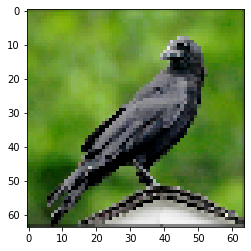

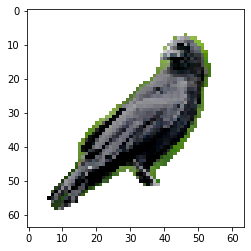

In [0]:
plt.imshow(testX[100])
plt.show()

mask = predict(testX[100])
plt.imshow(removeBg(testX[100],mask))
plt.show()

As you can see, the model has learned to remove the background pretty well. It tends to work better with images with distinct backgrounds. With more training time and a larger dataset (such as the CamVid dataset used in the Tiramisu paper) the model will get better at background removal. Thanks for reading!

## References

[The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326)

[Review: FC-DenseNet — One Hundred Layers Tiramisu, Fully Convolutional DenseNet (Semantic Segmentation)](https://towardsdatascience.com/review-fc-densenet-one-hundred-layer-tiramisu-semantic-segmentation-22ee3be434d5)

[Background Removal with Deep Learning](https://towardsdatascience.com/background-removal-with-deep-learning-c4f2104b3157?gi=14e278a7a5ad)